# Классификация

В данном блокноте мы с вами разберем пример классификации изображений при помощи сверточных нейронных сетей.
Проверим, что у нас установлены необходимые пакеты, в том числе пакет matplotlib для визуализации изображений.

In [1]:
!pip install numpy tensorflow tensorflow_datasets matplotlib

ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow


Как обычно, импортируем необходимые нам модули.

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import metrics, layers, activations, optimizers, losses

Снова будем использовать набор данных MNIST. Напомним, что этот набор данных содержит черно-белые картинки размером 28х28 пикселей, на каждой из которых изображена рукописная цифра от 0 до 9 включительно. Загрузим набор данных, разделим на тренировочный и тестовый наборы, а также зададим соответствующие константы.

In [3]:
ds_train, ds_test = tfds.load(
    'mnist',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True
)

batch_size = 10     
input_shape = (28, 28, 1)  
amount_of_classes = 10

2022-07-21 16:20:17.917827: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
Metal device set to: Apple M1 Pro


2022-07-21 16:20:22.246639: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-21 16:20:22.247337: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Так как метка класса — целое число в диапазоне от $0$ до $9$, то для дальнейшего использования библиотек разумным будет преобразовать метки при помощи one-hot encoding.

In [4]:
def make_one_hot(x, y):
    return x, tf.one_hot(y, depth=amount_of_classes)

ds_train = (
    ds_train
    .map(make_one_hot)
    .shuffle(len(ds_train))
    .batch(batch_size, drop_remainder=True)
)
    
ds_test = (
    ds_test
    .map(make_one_hot)
    .shuffle(len(ds_test))
    .batch(batch_size, drop_remainder=True)
)

Давайте посмотрим на изображения в загруженном наборе данных. Для этого визуализируем их с помощью пакета matplotlib, в заголовке картинок выведем метки класса каждого из изображений.

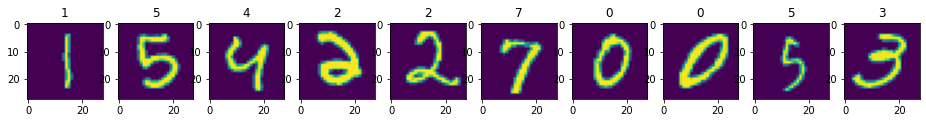

In [13]:
for example in ds_test.take(1):
    images, labels = example

f, axarr = plt.subplots(1, batch_size)
f.set_size_inches(16, 24)
for i in range(batch_size):
    axarr[i].imshow(images.numpy()[i].reshape(28, 28))
    axarr[i].set_title(str(labels.numpy()[i].tolist().index(1)))

Для успешной классификации нам необходимо создать нейронную сеть, которая будет иметь несколько сверточных слоев для анализа изображения и вычленения важных признаков, несколько пулинг слоев для сокращения количества параметров, а далее несколько полносвязных слоев.

Создадим модель и добавим в начале несколько сверточных слоев с ядром свертки $3 \times 3$ и шагом $1$, а также пулинг слоев с окном $2 \times 2$.
Далее мы можем воспользоваться специализированным слоем фреймворка Keras — Flatten. Этот слой преобразовывает многомерный тензор в одномерный для того, чтобы в дальнейшем его можно было подать на вход полносвязному слою. Этот слой вам придется использовать почти всегда при создании сетей со сверточными и полносвязными слоями.

После этого добавим несколько полносвязных слоев и выведем итоговую структуру сети.

In [15]:
model = keras.Sequential()
model.add(layers.Input(input_shape))
model.add(layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(amount_of_classes, activation=activations.softmax))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 128)               5

Примерно так выглядит типичная модель для классификации изображений, созданная на основе сверточных и полносвязных слоев. В случае задачи регрессии, к примеру, разница будет лишь в последнем слое, где нам необходимо будет изменить количество нейронов на количество предсказываемых переменных, а также убрать функцию активации (иначе — оставить линейную). Однако, данная модель не включает в себя множество изменений, предложенных в современных архитектурах (таких, как ResNet) и ее стоит рассматривать лишь как базовую — для решения достаточно простых задач.

В дальнейшем мы вам рекомендуем переиспользовать архитектуры существующих опубликованных моделей.

Скомпилируем модель, выбрав оптимизатор, функцию потерь и отслеживаемые метрики. Выбор подходит для решения задачи многоклассовой классификации.

In [16]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss=losses.CategoricalCrossentropy(),
    metrics=[metrics.CategoricalAccuracy()]
)

history = model.fit(ds_train, epochs=3, validation_data=ds_test, verbose=1)

Epoch 1/3


2022-07-21 16:36:18.946058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4797/4800 [============================>.] - ETA: 0s - loss: 0.6546 - categorical_accuracy: 0.8351

2022-07-21 16:36:55.896841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4800/4800 [==============================] - 43s 9ms/step - loss: 0.6544 - categorical_accuracy: 0.8352 - val_loss: 0.4914 - val_categorical_accuracy: 0.8591
Epoch 2/3
4800/4800 [==============================] - 40s 8ms/step - loss: 0.4978 - categorical_accuracy: 0.8607 - val_loss: 0.5219 - val_categorical_accuracy: 0.8783
Epoch 3/3
4800/4800 [==============================] - 41s 8ms/step - loss: 0.5441 - categorical_accuracy: 0.8547 - val_loss: 0.4260 - val_categorical_accuracy: 0.8816


После успешного завершения процесса обучения мы можем проверить нашу модель визуально, предсказав моделью значения для некоторых картинок из тестового набора данных, а затем сравнить их с настоящими метками.

1/1 [==============================] - 0s 53ms/step


2022-07-21 16:38:22.955971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


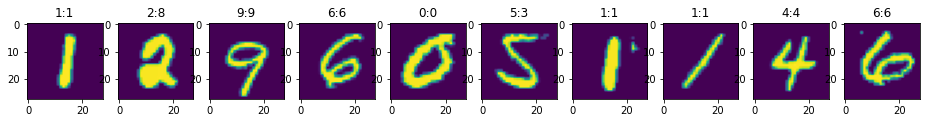

In [17]:
for example in ds_test.take(1):
    images, labels = example

x = model.predict(images)

f, axarr = plt.subplots(1, batch_size)
f.set_size_inches(16, 24)

for i in range(batch_size):
    axarr[i].imshow(images.numpy()[i].reshape(28, 28))
    axarr[i].set_title(
        str(labels.numpy()[i].tolist().index(1))    # ground truth
        + ":" + str(x.argmax(axis=1)[i])            # predicted
    )
